<a href="https://colab.research.google.com/github/SmitaPaul7000/CaseStudies/blob/master/1.0%20Image%20Captioning/Code/1_1_Imag_Cap_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project : Image Caption


### Map Google Drive

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.Import Data

In [0]:
#Import Necessary Libraries
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from PIL import Image
import string
from pickle import load

from numpy import array
import tensorflow
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

*  Loaded the VGG model in Keras using the VGG class.
*  VGG16 model used for loading features from images.
*  Remove the last layer from the loaded model, as this is the model used to predict a classification for a photo. 
*  Intension is not to classifying images, but we are interested in the internal representation of the photo right before a classification is made. 
*  These are the “features” that the model has extracted from the photo.
*  Below is a function named extract_features() that, given a directory name, will load each photo, prepare it for VGG, and collect the predicted features from the VGG model. 
*  The image features are a 1-dimensional 4,096 element vector.
*  The function returns a dictionary of image identifier to image features.



In [0]:
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    #print(model.summary())
    # re-structure the model

    # remove last output layer from vgg16
    model.layers.pop()
    # print(model.summary())

    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    #print(model.summary())

    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name

        # for loading an image from file as a PIL image object.
        image = load_img(filename, target_size=(224, 224))
        #print(image)

        # convert the image pixels to a numpy array
        image = img_to_array(image)
        #print(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        #print(image)

        # prepare the image for the VGG model
        image = preprocess_input(image)
        #print("1.2")
        #print(image)

        # get features
        feature = model.predict(image, verbose=0)
        #print("1.3")
        #print(feature)
        #print(feature.shape)
    
        # get image id
        image_id = name.split('.')[0]
        #print(image_id)
        # store feature
        features[image_id] = feature
        # print('>%s' % name)
        #break
    return features



# 2.Features extraction using VGG16 for all 8K Images


Pass directory contain all Images and call extract_features function to extract features


In [38]:
%%time
## Wall time: 20min 7s
## Wall time: 2min 20s
# extract features from all images
directory = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))

Extracted Features: 8091
CPU times: user 1min 20s, sys: 12.2 s, total: 1min 32s
Wall time: 2min 20s


Check images in folders

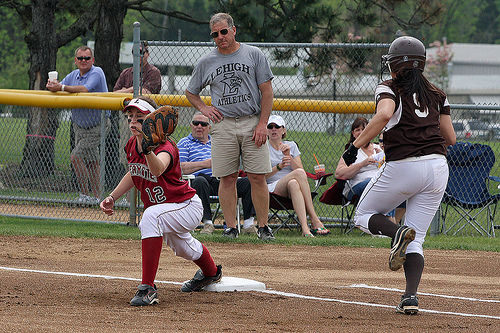

In [39]:
Image.open('/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/3517040752_debec03376.jpg')

In [41]:
features['3517040752_debec03376'].shape
#features[''] 

(1, 4096)

# 3.Save all Image features in file AllImageFeatures.pkl, into google drive


In [0]:
feature_save_name = 'AllImageFeatures_8K.pkl'
path = F"/content/drive/My Drive/Colab Notebooks/_ic/results/{feature_save_name}"
dump(features, open(path, 'wb')) 

# 4.Image id and desciption

Create dictionary with image id and image description

*  The dataset contains multiple descriptions for each photograph and the text of the descriptions requires some minimal cleaning.
*  Each photo has a unique identifier. This identifier is used on the photo filename and in the text file of descriptions.

**Below code will map each photo identifier with list of one or more textual descriptions.**



In [0]:
#Flickr8k.token.txt contain image id and 3-4 line description for image
#
Flickr8k_token_filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr8k.token.txt'

# load descriptions
file = open(Flickr8k_token_filename, 'r')
doc = file.read()
file.close() 

mapping = dict()
#i = 1
# process lines
for line in doc.split('\n'):
  # split line by white space
  tokens = line.split()
  if len(line) < 2:
    continue
  # take the first token as the image id, the rest as the description
  image_id, image_desc = tokens[0], tokens[1:]
  # remove filename from image id
  image_id = image_id.split('.')[0]
  # convert description tokens back to string
  image_desc = ' '.join(image_desc)
  
  # create the list if needed, else appende description to existing image id
  if image_id not in mapping:
    mapping[image_id] = list()
    # store description
  mapping[image_id].append(image_desc)    
  #i = i+1
  #if i==10 :
  #  break
Flickr8k_token_descriptions =mapping
'''
Flickr8k_token_descriptions == >
{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
 '''

4.2 Text preprocessing, cleaning up data


Clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

1.  Convert all words to lowercase.
2.  Remove all punctuation.
3.  Remove all words that are one character or less in length (e.g. ‘a’).
4.  Remove all words with numbers in them.



** -- TO DO: add move clean up steps


In [0]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
for key, desc_list in Flickr8k_token_descriptions.items():
  for i in range(len(desc_list)):
    desc = desc_list[i]
    # tokenize
    desc = desc.split()
    # convert to lower case
    desc = [word.lower() for word in desc]
    # remove punctuation from each token
    desc = [w.translate(table) for w in desc]
    # remove hanging 's' and 'a'
    desc = [word for word in desc if len(word)>1]
    # remove tokens with numbers in them
    desc = [word for word in desc if word.isalpha()]
    # store as string
    desc_list[i] =  ' '.join(desc)

In [72]:
desc_list

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

4.3 Convert the loaded descriptions (text) into a vocabulary of words

*  Once cleaned, we can summarize the size of the vocabulary.
*  Ideally, we want a vocabulary that is both expressive and as small as possible. A smaller vocabulary will result in a smaller model that will train faster.
*  For reference, we can transform the clean descriptions into a set and print its size to get an idea of the size of our dataset vocabulary.


In [46]:
# build a list of all description strings
all_desc = set()
for key in Flickr8k_token_descriptions.keys():
  [all_desc.update(d.split()) for d in Flickr8k_token_descriptions[key]]

len(all_desc)

8763

In [79]:
for d in Flickr8k_token_descriptions['2095478050_736c4d2d28']:
  print(d.split())

['man', 'and', 'boy', 'play', 'music', 'as', 'little', 'girls', 'watch']
['man', 'is', 'playing', 'guitar', 'with', 'child', 'playing', 'harmonica', 'while', 'three', 'young', 'girls', 'watch']
['three', 'children', 'watch', 'man', 'onstage', 'playing', 'guitar']
['three', 'little', 'girls', 'look', 'on', 'as', 'boy', 'plays', 'the', 'harmonica', 'with', 'an', 'adult', 'guiutarist', 'sitting', 'beside', 'him']
['three', 'little', 'girls', 'watch', 'band']


In [81]:
len(Flickr8k_token_descriptions)


8092

In [48]:
all_desc
type(desc_list)
'''
{'emerging',
 'venture',
 'focusing',
 'knife',
 'blooming',
 'passenger',
 'beatup',
 '''

"\n{'emerging',\n 'venture',\n 'focusing',\n 'knife',\n 'blooming',\n 'passenger',\n 'beatup',\n "

4.4 Save descriptions to file, one per line : AllImageDescriptions.txt


Finally, we can save the dictionary of image identifiers and descriptions to a new file named AllImageDescriptions_8K.txt, with one image identifier and description per line.

In [0]:
# save descriptions to file, one per line
lines = list()
for key, desc_list in Flickr8k_token_descriptions.items():
  for desc in desc_list:
    lines.append(key + ' ' + desc)
data = '\n'.join(lines)


In [0]:
desc_save_name = 'AllImageDescriptions_8K.txt'
path = F"/content/drive/My Drive/Colab Notebooks/_ic/results/{desc_save_name}"
# dump(features, open(path, 'wb')) 

file = open(path, 'w')
file.write(data)
file.close()

# 5.Develop Deep Learning Model
## Load Train data from Flickr_8k.trainImages.txt
*  Load the prepared photo and text data so that we can use it to fit the model.
*  Train the data on all of the photos and captions in the training dataset. 
*  The train and development dataset have been predefined in the Flickr_8k.trainImages.txt and Flickr_8k.devImages.txt files respectively, that both contain lists of photo file names. 
*  From these file names, we can extract the photo identifiers and use these identifiers to filter photos and descriptions for each set.
*  Below code will load a pre-defined set of identifiers given the train or development sets filename.


5.1 Train Images data

In [0]:
# load a pre-defined list of photo identifiers
Flickr_8k_trainImages_filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr_8k.trainImages.txt'
file = open(Flickr_8k_trainImages_filename, 'r')
train_img_id_data = file.read()
file.close()

train_img_id_dataset = list()
# process line by line
for line in train_img_id_data.split('\n'):
  # skip empty lines
  if len(line) < 1:
    continue
  # get the image identifier
  identifier = line.split('.')[0]
  train_img_id_dataset.append(identifier)


In [52]:
type(train_img_id_dataset)
train_img_id_dataset[:10]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154']

5.2 Train Image descriptions with startseq and endseq


*  Loads the cleaned text descriptions from 'AllImageDescriptions_8K.txt' for a given set of train identifiers and returns a dictionary of identifiers to lists of text descriptions.
* The model we will develop will generate a caption given a photo, and the caption will be generated one word at a time. 
*  The sequence of previously generated words will be provided as input. 
*  Therefore, we will need a ‘first word’ to kick-off the generation process and a ‘last word‘ to signal the end of the caption.
*  We will use the strings ‘startseq‘ and ‘endseq‘ for this purpose. 
*  These tokens are added to the loaded descriptions as they are loaded. 
*  It is important to do this now before we encode the text so that the tokens are also encoded correctly.


In [0]:

# load document
filename = '/content/drive/My Drive/Colab Notebooks/_ic/results/AllImageDescriptions_8K.txt'
file = open(filename, 'r')
all_desc_8k = file.read()
file.close()

train_descriptions = dict()
for line in all_desc_8k.split('\n'):
  # split line by white space
  tokens = line.split()

  # split id from description
  image_id, image_desc = tokens[0], tokens[1:]
  
  # skip images not in the set
  if image_id in train_img_id_dataset:
    # create list
    if image_id not in train_descriptions:
      train_descriptions[image_id] = list()

    # wrap description in tokens
    desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
    
    # store
    train_descriptions[image_id].append(desc)

'''
train_descriptions
{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
'''


In [0]:
#len(features) #, len(all_features)



5.3 Image id and its features from VGG16

Load features for Train Image set from AllImageFeatures_8K.pkl

In [0]:
# photo features
# load all image features
filename = '/content/drive/My Drive/Colab Notebooks/_ic/results/AllImageFeatures_8K.pkl'
all_features = load(open(filename, 'rb'))
# filter features
train_img_features = {k: all_features[k] for k in train_img_id_dataset}


In [56]:
len(train_img_features) , len(all_features)

(6000, 8091)

# Traning Dataset

In [0]:
#tokenizer = create_tokenizer(train_descriptions)
#lines = to_lines(descriptions)
all_desc = list()
for key in train_descriptions.keys():
  [all_desc.append(d) for d in train_descriptions[key]]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_desc)

vocab_size = len(tokenizer.word_index) + 1


In [89]:
vocab_size


7579

Calculate the maximum number of words in the longest description.

In [59]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
#max_length = max_length(train_descriptions)
# print('Description Length: %d' % max_length)
#lines = to_lines(descriptions)
all_desc = list()
for key in train_descriptions.keys():
  [all_desc.append(d) for d in train_descriptions[key]]

max_length =  max(len(d.split()) for d in lines)
print('Description Length: %d' % max_length)

Vocabulary Size: 7579
Description Length: 33


In [90]:
len(train_descriptions)

6000

# 6.Train the model

*  There are two input arrays to the model: one for photo features and one for the encoded text.
*  There is one output for the model which is the encoded next word in the text sequence.
*  The input text is encoded as integers, which will be fed to a word embedding layer. 
*  The photo features will be fed directly to another part of the model. 
*  The model will output a prediction, which will be a probability distribution over all words in the vocabulary.
*  The output data will therefore be a one-hot encoded version of each word, representing an idealized probability distribution with 0 values at all word positions except the actual word position, which has a value of 1.

    #### We will describe the model in three parts:
1.  Photo Feature Extractor. 
    This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.
2.  Sequence Processor. 
    This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.
3.  Decoder (for lack of a better name). 
    Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction.

*  The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. 
*  These are processed by a Dense layer to produce a 256 element representation of the photo.
*  The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. 
*   This is followed by an LSTM layer with 256 memory units.
*   Both the input models produce a 256 element vector. 
*   Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.
* The Decoder model merges the vectors from both input models using an addition operation. 
*  This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

categorical_crossentropy used in multiclass classification loss


In [60]:
%%time
# train the model
# model = define_model(vocab_size, max_length)


# feature extractor model
# 4096 neurons -> FullyConnected NN ->256
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


# sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)


model.compile(loss='categorical_crossentropy', optimizer='adam')


# summarize model
print(model.summary())

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:

		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)
 
'''
The yield statement suspends function’s execution and sends a value back to 
the caller, but retains enough state to enable function to resume where it is 
left off. When resumed, the function continues execution immediately after the 
last yield run. This allows its code to produce a series of values over time,
rather than computing them at once and sending them back like a list.
'''
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
			yield [[in_img, in_seq], out_word]

# train the model, run epochs manually and save after each epoch
#epochs = 20
epochs = 1
steps = len(train_descriptions)

#To Do: chk code epoch...
# it cud be written better way
for i in range(epochs):
	# create the data generator
	# pass all input HERE
	#generator = data_generator(train_descriptions, train_features1, tokenizer, max_length)
	
	generator = data_generator(train_descriptions, train_img_features, tokenizer, max_length)
 

	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
 
	# save model for each epoch
	#model.save('model_' + str(i) + '.h5')
	model_save_name = 'NewModel_' + str(i) + '.h5'
	model_path = F"/content/drive/My Drive/Colab Notebooks/_ic/results/{model_save_name}"
	model.save(model_path)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 33, 256)      1940224     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_5[0][0]                    
____________________________________________________________________________________________

# 7.Evaluate Model

Once the model is fit, we can evaluate the skill of its predictions on the holdout test dataset.

First, we need to be able to generate a description for a photo using a trained model.

This involves passing in the start description token 'startseq', generating one word, then calling the model recursively with generated words as input until the end of sequence token is reached 'endseq' or the maximum description length is reached.

Below code generates a textual description given a trained model, and a given prepared photo as input. 



In [61]:
# prepare test set

# load test set
Flickr_8k_testImages_filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr_8k.testImages.txt'
#test = load_set(filename)
file = open(Flickr_8k_testImages_filename, 'r')
test_img_id_data = file.read()
file.close()

dataset = list()
# process line by line
for line in test_img_id_data.split('\n'):
  # skip empty lines
  if len(line) < 1:
    continue
  # get the image identifier
  identifier = line.split('.')[0]
  dataset.append(identifier)
test_img_id =set(dataset)

print('Dataset: %d' % len(test_img_id))


Dataset: 1000


In [62]:
# descriptions
#test_descriptions = load_clean_descriptions('descriptions.txt', test)
file = open('/content/drive/My Drive/Colab Notebooks/_ic/results/AllImageDescriptions_8K.txt', 'r')
all_desc_8k = file.read()
file.close()

# load document
#doc = load_doc(filename)
descriptions = dict()
for line in all_desc_8k.split('\n'):
  # split line by white space
  tokens = line.split()
  # split id from description
  image_id, image_desc = tokens[0], tokens[1:]
  # skip images not in the set
  if image_id in dataset:
    # create list
    if image_id not in descriptions:
      descriptions[image_id] = list()
    # wrap description in tokens
    desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
    # store
    descriptions[image_id].append(desc)
test_img_descriptions = descriptions


print('Descriptions: test=%d' % len(test_img_descriptions))


Descriptions: test=1000


In [0]:
# for k in test_img_descriptions:
#   print(k)
#   break

7.3 test photo features

In [64]:
# photo features
#test_features = load_photo_features('features.pkl', test)
# load all features
all_features = load(open('/content/drive/My Drive/Colab Notebooks/_ic/results/AllImageFeatures_8K.pkl', 'rb'))
# filter features
features = {k: all_features[k] for k in test_img_descriptions}
test_img_features = features

print('Photos: test=%d' % len(test_img_features))


Photos: test=1000


7.4 load the model which has minimum loss

In [0]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
  
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]

		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		
		# convert probability to integer
		yhat = argmax(yhat)
		
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		
		# stop if we cannot map the word
		if word is None:
			break
		
		# append as input for generating the next word
		in_text += ' ' + word
		
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	
	return in_text

#8 Metric Bleu

This evaluate a trained model against a given dataset of photo descriptions and photo features. 
The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text.

BLEU scores are used in text translation for evaluating translated text against one or more reference translations.

Here, we compare each generated description against all of the reference descriptions for the photograph. We then calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.

In [0]:
def predict_n_chk_score(model_nm):
  model = load_model(model_nm)
  # evaluate model
  #evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

  # evaluate the skill of the model
  #def evaluate_model(model, descriptions, photos, tokenizer, max_length):
  actual, predicted = list(), list()

  # step over the whole set
  for key, desc_list in test_img_descriptions.items():

    # generate description
    yhat = generate_desc(model, tokenizer, test_img_features[key], max_length)
    
    # store actual and predicted
    references = [d.split() for d in desc_list]
    
    actual.append(references)
    predicted.append(yhat.split())


  # calculate BLEU score
  # cumulative scores for BLEU-1, BLEU-2, BLEU-3 and BLEU-4:
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))



In [0]:
# stopwords = ['startseq','endseq']

# #Remove startseq and endseq
# #query = actual[0]
# #stopwords = ['startseq','endseq']
# #querywords = query.split()

# #resultwords  = [word for word in query if word not in stopwords]
# #result = ' '.join(resultwords)
# #result = resultwords

# #print(result)

# #Remove startseq and endseq


# # #Remove startseq and endseq
# # query = actual[0]
# querywords =   actual[0]

# # resultwords  = [querywords for querywords in query ]
# # result = ' '.join(resultwords)
# # #result = resultwords

# # print(result)

# from functools import reduce 
# from pandas.core.common import flatten


# flatten = lambda l: [item for sublist in querywords for item in sublist]
# #print(flatten)

# #print(reduce(querywords))
# query= list(flatten(querywords))
# querywords = query#.split()

# #resultwords  = [querywords for querywords in query ]
# resultwords  = [word for word in querywords if word.lower() not in stopwords]

# result = ' '.join(resultwords)
# print("Actual : " , result)


# query = predicted[0]
# stopwords = ['startseq','endseq']
# querywords =  predicted[0]


# #resultwords  = [querywords for querywords in query ]
# resultwords  = [word for word in querywords if word.lower() not in stopwords]

# result = ' '.join(resultwords)
# #result = resultwords

# print("Predicted : " , result)

# #test_img_features['1056338697_4f7d7ce270']
# Image.open('/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/1056338697_4f7d7ce270.jpg')



In [0]:
#actual[1]

In [0]:
#redicted[1]

In [0]:
predict_n_chk_score('/content/drive/My Drive/Colab Notebooks/_ic/results/NewModel_0.h5')
'''BLEU-1: 0.558747
BLEU-2: 0.305061
BLEU-3: 0.209501
BLEU-4: 0.095505'''

In [0]:
predict_n_chk_score('/content/drive/My Drive/Colab Notebooks/_ic/results/model_2.h5')

In [0]:
predict_n_chk_score('/content/drive/My Drive/Colab Notebooks/_ic/results/model_8.h5')

In [0]:
predict_n_chk_score('/content/drive/My Drive/Colab Notebooks/_ic/results/model_9.h5')

In [0]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test','pole']]
candidate = ['pole','this', 'is', 'test']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

In [0]:
# 4-gram cumulative BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)

In [0]:
# cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

#9.to do:pls check actual and predicted sentence with images


In [0]:
num_tests = 2
for tests in range(num_tests):
  image_num = random.randint(0, sample_size - 1)
  caption = sess.run(final_prediction, feed_dict = {x_inp:train[image_num:image_num + 1]})
  print(caption.shape)
  caption = np.argmax(caption[:-1], 1)
  capt = ''
  for i in caption:
      capt += rev_dict[i] + ' '
  print('Predicted Caption:->', capt)
  orig_cap = np.argmax(train_caption[image_num:image_num + 1][0][1:-1].A, 1)
  orignalcaption = ''
  for i in orig_cap:
      orignalcaption += rev_dict[i] + ' '
  print('Orignal Caption:->', orignalcaption)
  plt.imshow(real_images[image_num])
  plt.title('Image')
  plt.show()

# 10.Generate caption for Fresh image


In [0]:
#Generate Captions for a Fresh Image

from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# load the tokenizer
#tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 33
# load the model
model = load_model('model_4.h5')
# load and prepare the photograph
#photo = extract_features('Sample_Image.jpg')
photo = extract_features('/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 1/fruits-2.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)
#startseq man rides bike on dirt path endseq


In [0]:

#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

In [0]:
type(description)
type(querywords)

In [0]:
####################################################